In [1]:
import copy
from enum import Enum
import contextlib
import sys
from pathlib import Path
from typing import List

import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from tqdm.contrib import DummyTqdmFile

mi.set_variant("cuda_ad_rgb")

from mimt import *
set_siggraph_font()

class Setting(Enum):
    Direct = 1
    VaryingBRDF = 2
    IndirectIllumination = 3
    DirectZoomed = 4
    VaryingBRDFZoomed = 5
    IndirectIlluminationZoomed = 6    

In [2]:
def create_scene(setting: Setting, integrator: str, samples: int=50**2):
    texture = create_gradient_image(128, 128, color_1=[1, 0, 0], color_2=[0, 1, 0])
    texture[:, :, 2] = 0.05
    
    scale = [0.75, 10]
    if setting in [Setting.DirectZoomed, Setting.VaryingBRDFZoomed, Setting.IndirectIlluminationZoomed]:
        scale = [0.24, 0.75]
        
    scene_dict = {
        "type": "scene",

        "integrator": {
            "type": integrator,
            "max_depth": 2,
            "hide_emitters": False,
        },

        "sensor": {
            "type": "perspective",
            "to_world": mi.ScalarTransform4f().look_at(
                origin = [0, 0,  0],
                target = [0, 0, -1],
                up=[0, 1, 0]
            ),
            "film": {
                "type": "hdrfilm",
                "rfilter": { "type": "gaussian" },
                "width": 128,
                "height": 128,
                "sample_border": True,
            },
            "sampler": { "type": "independent", "sample_count": samples, },
        },

        "surface_1": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f().look_at(
                origin = [0,  0, -1],
                target = [0+ 0, -1+ 0,  1+ -1],
                up=[0, 1, 0]
            ).scale(scale[0]),
        },

        "surface_2": {
            "type": "rectangle",
            "to_world": mi.ScalarTransform4f().look_at(
                origin = [0, -2, -1],
                target = [0, 1+ -2,  0+ -1],
                up=[0, 0, 1]
            ).scale(scale[1]),
            "emitter": { 
                "type": "area",
                "radiance": {
                    'type': 'bitmap',
                    'data': 2*texture,
                    'raw': True
                },
            }
        },
    }        
    if setting == Setting.VaryingBRDFZoomed or setting == Setting.IndirectIlluminationZoomed:
        scene_dict["surface_2"]["emitter"]["radiance"]["data"] *= 5.0
        
    if setting == Setting.Direct or setting == Setting.DirectZoomed:
        # Make the first surface an emitter and remove the second surface
        scene_dict["surface_1"]["emitter"] = scene_dict["surface_2"]["emitter"] 
        del scene_dict["surface_2"]
        
    elif setting == Setting.VaryingBRDF or setting == Setting.VaryingBRDFZoomed:
        factor = 0.15
        if setting == Setting.VaryingBRDFZoomed:
            factor = 1
        scene_dict["surface_1"]["bsdf"] = {
            "type": "diffuse",
            'reflectance': {
                'type': 'bitmap',
                'data': factor*texture,
                'raw': True
            }
        }
        scene_dict["surface_2"]["emitter"]["radiance"] = {
            'type': 'rgb',
            'value': 15.0,
        }

    return scene_dict
    # scene_dict_overview = scene_dict.copy()
    # scene_dict_overview["sensor"] = scene_dict["sensor"].copy()
    # scene_dict_overview["sensor"]["to_world"] = mi.ScalarTransform4f.look_at(
    #     origin=[4, 4, 4], target=[0, 0, 0], up=[0, 1, 0]
    # )

def apply_transform(params: mi.SceneParameters, original: mi.Transform4f, offset: float):
    params['surface_1.to_world'] = mi.Transform4f().translate([0, 0, -offset]) @ original
    params.update()
    return params

In [3]:
@contextlib.contextmanager
def std_out_err_redirect_tqdm():
    orig_out_err = sys.stdout, sys.stderr
    try:
        sys.stdout, sys.stderr = map(DummyTqdmFile, orig_out_err)
        yield orig_out_err[0]
    # Relay exceptions
    except Exception as exc:
        raise exc
    # Always restore sys.stdout/err if necessary
    finally:
        sys.stdout, sys.stderr = orig_out_err
        
def generate_data(integrators: List[str], settings: List[Setting], samples: int=50**2):
    data = {}

    # Generate the data for the gi
    with std_out_err_redirect_tqdm() as orig_stdout:
        for setting_idx, setting in enumerate(tqdm(settings, desc="settings", leave=False, file=orig_stdout, dynamic_ncols=True)):
            setting_key = f"Setting {setting_idx+1}"
            data[setting_key] = []
            tqdm.write(str(setting))
            for integrator in (pbar:= tqdm(integrators, leave=False, desc="integrator", file=orig_stdout, dynamic_ncols=True)):
                tqdm.write("    "+integrator)
                pbar.set_postfix_str(integrator)
                scene = mi.load_dict(create_scene(setting, integrator=integrator.lower(), samples=samples))
    
                params   = mi.traverse(scene)
                original = mi.Transform4f(params['surface_1.to_world'])

                # Render primal image
                img = mi.render(scene, params=params, seed=10)
    
                # Compute gradients
                render_with_offset = lambda x: mi.render(scene, params=apply_transform(params, original, x), seed=0)
                grad_fd = compute_gradient_finite_differences(render_with_offset, 0., h=0.001)
                grad_fw = compute_gradient_forward(render_with_offset, 0.)
                
                data[setting_key].append((integrator, img, grad_fd, grad_fw))
    return data

# Figure 1

settings:   0%|          | 0/3 [00:00<?, ?it/s]

Setting.Direct


integrator:   0%|          | 0/3 [00:00<?, ?it/s]

    prb
    prb_projective


2025-03-31 14:52:58 WARN main [projective.py:481] init_indirect_silhouette_octree(): No valid indirect silhouette samples were found in the scene. Please check the scene and the camera settings. If no indirect discontinuous derivatives exists in the scene, it is more efficient to set `sppi` to 0.

    ad
Setting.VaryingBRDF


integrator:   0%|          | 0/3 [00:00<?, ?it/s]

    prb
    prb_projective


2025-03-31 14:52:59 WARN main [projective.py:481] init_indirect_silhouette_octree(): No valid indirect silhouette samples were found in the scene. Please check the scene and the camera settings. If no indirect discontinuous derivatives exists in the scene, it is more efficient to set `sppi` to 0.

    ad
Setting.IndirectIllumination


integrator:   0%|          | 0/3 [00:00<?, ?it/s]

    prb
    prb_projective


2025-03-31 14:53:00 WARN main [projective.py:481] init_indirect_silhouette_octree(): No valid indirect silhouette samples were found in the scene. Please check the scene and the camera settings. If no indirect discontinuous derivatives exists in the scene, it is more efficient to set `sppi` to 0.

    ad


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.34918937..1.3015997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.31812888..1.2427286].


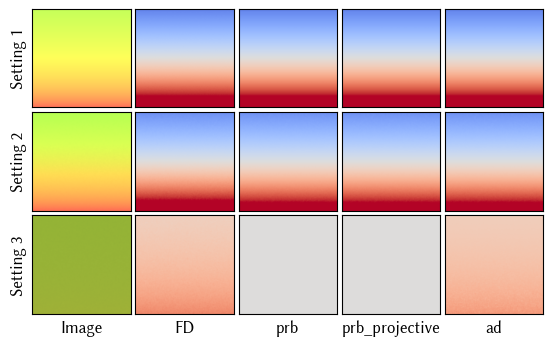

In [4]:
integrators = ["prb", "prb_projective", "ad"]
settings    = [Setting.Direct, Setting.VaryingBRDF, Setting.IndirectIllumination] # First two settings succeed with prb_reparam

data = generate_data(integrators, settings, 50**2)
generate_figure(integrators, data, Path("output/case_1.pdf"))

# Figure 2

settings:   0%|          | 0/3 [00:00<?, ?it/s]

Setting.Direct


integrator:   0%|          | 0/3 [00:00<?, ?it/s]

    prb_threepoint
    ad_threepoint
    ad
Setting.VaryingBRDF


integrator:   0%|          | 0/3 [00:00<?, ?it/s]

    prb_threepoint
    ad_threepoint
    ad
Setting.IndirectIllumination


integrator:   0%|          | 0/3 [00:00<?, ?it/s]

    prb_threepoint
    ad_threepoint
    ad


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.34917662..1.3015623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.32093444..1.2361224].


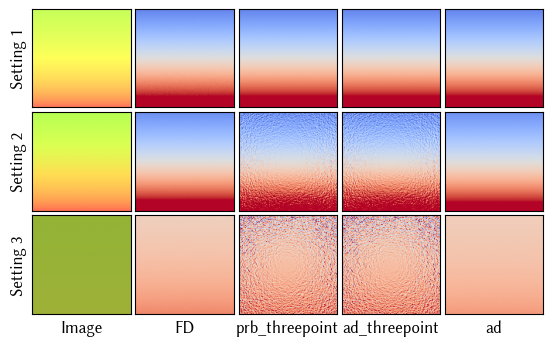

In [6]:
integrators = ["prb_threepoint", "ad_threepoint", "ad"]
settings    = [Setting.Direct, Setting.VaryingBRDF, Setting.IndirectIllumination] # First two settings succeed with prb_reparam

data = generate_data(integrators, settings, 250**2)
generate_figure(integrators, data, Path("output/case_1_threepoint.pdf"))

# Figure 3

settings:   0%|          | 0/3 [00:00<?, ?it/s]

Setting.DirectZoomed


integrator:   0%|          | 0/3 [00:00<?, ?it/s]

    prb_threepoint
    prb_projective


2025-03-31 15:33:47 WARN main [projective.py:481] init_indirect_silhouette_octree(): No valid indirect silhouette samples were found in the scene. Please check the scene and the camera settings. If no indirect discontinuous derivatives exists in the scene, it is more efficient to set `sppi` to 0.

    ad
Setting.VaryingBRDFZoomed


integrator:   0%|          | 0/3 [00:00<?, ?it/s]

    prb_threepoint
    prb_projective


2025-03-31 15:34:05 WARN main [projective.py:481] init_indirect_silhouette_octree(): No valid indirect silhouette samples were found in the scene. Please check the scene and the camera settings. If no indirect discontinuous derivatives exists in the scene, it is more efficient to set `sppi` to 0.

    ad
Setting.IndirectIlluminationZoomed


integrator:   0%|          | 0/3 [00:00<?, ?it/s]

    prb_threepoint
    prb_projective


2025-03-31 15:34:21 WARN main [projective.py:481] init_indirect_silhouette_octree(): No valid indirect silhouette samples were found in the scene. Please check the scene and the camera settings. If no indirect discontinuous derivatives exists in the scene, it is more efficient to set `sppi` to 0.

    ad


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3424058].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3191421].


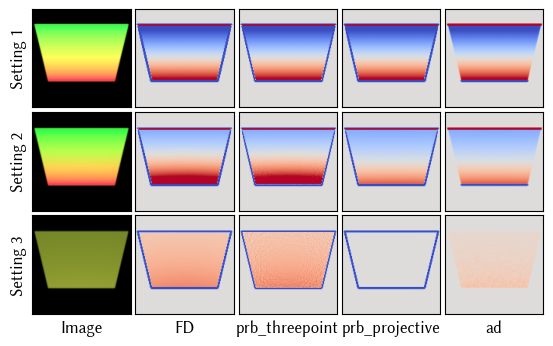

In [4]:
integrators = ["prb_threepoint", "prb_projective", "ad"]
settings    = [Setting.DirectZoomed, Setting.VaryingBRDFZoomed, Setting.IndirectIlluminationZoomed] # First two settings succeed with prb_reparam

data = generate_data(integrators, settings, 200**2)
generate_figure(integrators, data, Path("output/case_1_full_visibility.pdf"))